In [129]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import regex as re
from sklearn.preprocessing import StandardScaler

In [2]:
## locations

train_data_location = "data/train.csv"
test_data_location = "data/test.csv"


In [133]:
df_train = pd.read_csv(train_data_location)

In [134]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


##### Observation: there are some nulls in Age and Cabin, we will need to treat them.

In [135]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [136]:
cat_columns = set(df_train.columns) - set(df_train.describe().columns)
for col in cat_columns:
    print("-----------------------------------------------------")
    print(f"Column: {col} with unique values: {len(df_train[col].unique())}")
    print(df_train[col].unique())
    print("-----------------------------------------------------")

-----------------------------------------------------
Column: Sex with unique values: 2
['male' 'female']
-----------------------------------------------------
-----------------------------------------------------
Column: Embarked with unique values: 4
['S' 'C' 'Q' nan]
-----------------------------------------------------
-----------------------------------------------------
Column: Name with unique values: 891
['Braund, Mr. Owen Harris'
 'Cumings, Mrs. John Bradley (Florence Briggs Thayer)'
 'Heikkinen, Miss. Laina' 'Futrelle, Mrs. Jacques Heath (Lily May Peel)'
 'Allen, Mr. William Henry' 'Moran, Mr. James' 'McCarthy, Mr. Timothy J'
 'Palsson, Master. Gosta Leonard'
 'Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)'
 'Nasser, Mrs. Nicholas (Adele Achem)' 'Sandstrom, Miss. Marguerite Rut'
 'Bonnell, Miss. Elizabeth' 'Saundercock, Mr. William Henry'
 'Andersson, Mr. Anders Johan' 'Vestrom, Miss. Hulda Amanda Adolfina'
 'Hewlett, Mrs. (Mary D Kingcome) ' 'Rice, Master. Eugene'
 'Will

### Feature extractions

In [137]:
reg_exp = r'\s[A-Za-z]+\.'
df_train['name_titles']= df_train.Name.apply(lambda x: re.search(reg_exp,x).group().strip() if re.search(reg_exp,x) else "NA")
df_train[['Name','name_titles']].head()

,Name,name_titles
0,"Braund, Mr. Owen Harris",Mr.
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",Mrs.
2,"Heikkinen, Miss. Laina",Miss.
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",Mrs.
4,"Allen, Mr. William Henry",Mr.


In [138]:
df_train['cabin_initial'] = df_train.Cabin.apply(lambda x: "NA" if  type(x)==float else str(x[0]).upper())

In [139]:
df_train['no_cabins'] = df_train.Cabin.apply(lambda x: 1 if type(x)==float else len(x.split(' ')))

In [140]:
df_train['relation_count'] = df_train['SibSp']+df_train['Parch']

### Analysing categorical variables and finding how they relate to survival

In [141]:
def pivot_table_column_perc(df,index,columns,values=None):
    if not values:
        values=index
    df_pivot = pd.pivot_table(df,index =index,values=values,columns=columns,aggfunc='count',fill_value=0).apply(lambda x:(x*100)/sum(x))
    return df_pivot

In [142]:
categorical_cols = ['Sex','Embarked','name_titles','cabin_initial','no_cabins','SibSp','Parch','Pclass','relation_count']
for col in categorical_cols:
    df_temp = pivot_table_column_perc(df_train,'Survived',col,'Name')
    print("--------------------------")
    print(df_temp.head())
    print("--------------------------")
    

--------------------------
Sex          female       male
Survived                      
0         25.796178  81.109185
1         74.203822  18.890815
--------------------------
--------------------------
Embarked          C          Q          S
Survived                                 
0         44.642857  61.038961  66.304348
1         55.357143  38.961039  33.695652
--------------------------
--------------------------
name_titles  Capt.  Col.  Countess.   Don.        Dr.  Jonkheer.  Lady.  \
Survived                                                                  
0            100.0  50.0        0.0  100.0  57.142857      100.0    0.0   
1              0.0  50.0      100.0    0.0  42.857143        0.0  100.0   

name_titles  Major.  Master.     Miss.  Mlle.   Mme.        Mr.  Mrs.    Ms.  \
Survived                                                                       
0              50.0     42.5  30.21978    0.0    0.0  84.332689  20.8    0.0   
1              50.0     57.5  69

##### Observations (categorical variables):
 1. Female had more chance of survival than male (interesting feature)
 2. People who onboarded on Q = Queenstown, S = Southampton had poorer chance of survival. (interesting feature)
 3. People with titles
     [a]. [Capt, Don, Jonkheer,Mr, Rev) --> high risk of death
     [b]. [Lady.,Miss., Mlle., Mme., Mrs., Ms., Sir.] ---> Low Risk of Death
     [c]. rest have medium risk
 4. Cabin Initials:
     [a]. People with cabins in between of the ship ie., B to E had better chance of survival , while people with extreme cabins ie, [A, G, T] are low chance of survival. could be due to water entering in the lower cabins quickly and the deck having damage.
     [b]. We need to find an imputation technique for NA.(we could look at titles of people present in the NA and then give a low and high risk rating)
     
 5. People having more than one cabin had higher chance of survival.
 6. If you had 1-2 siblings/spouse you had better chance as compared to more siblings/spouse and if you were all alone on the ship, similar kind of trend for parent/child present, maybe we should create a single variable which tells the presence of 1 or both. Overall if you have between 2-4 total relations onboard you had a better chance.
 7. the lower the pclass the worse the chance of survival.

### Analysing numerical variables and finding how they relate to survival

In [143]:
df_train.describe().columns

Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare',
       'no_cabins', 'relation_count'],
      dtype='object')

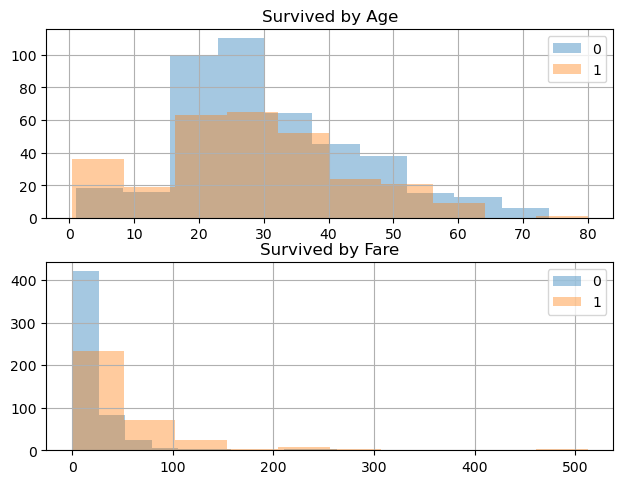

In [144]:
numeric_columns = ['Age','Fare',]
classification_column = ['Survived']
figure, axis = plt.subplots(len(numeric_columns), 1)
cnt=0
figure.tight_layout()
for col in numeric_columns:
    df_train.groupby(classification_column)[col].hist(alpha=0.4,legend=True,ax=axis[cnt])
    axis[cnt].set_title(f"Survived by {col}")
    cnt+=1

In [154]:
df_train['fare1'] = np.sqrt(df_train['Fare'])

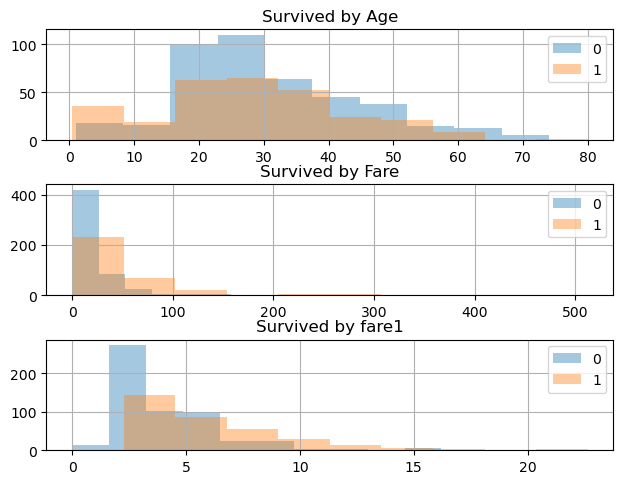

In [155]:
numeric_columns = ['Age','Fare','fare1']
classification_column = ['Survived']
figure, axis = plt.subplots(len(numeric_columns), 1)
cnt=0
figure.tight_layout()
for col in numeric_columns:
    df_train.groupby(classification_column)[col].hist(alpha=0.4,legend=True,ax=axis[cnt])
    axis[cnt].set_title(f"Survived by {col}")
    cnt+=1

In [157]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PassengerId     891 non-null    int64  
 1   Survived        891 non-null    int64  
 2   Pclass          891 non-null    int64  
 3   Name            891 non-null    object 
 4   Sex             891 non-null    object 
 5   Age             714 non-null    float64
 6   SibSp           891 non-null    int64  
 7   Parch           891 non-null    int64  
 8   Ticket          891 non-null    object 
 9   Fare            891 non-null    float64
 10  Cabin           204 non-null    object 
 11  Embarked        889 non-null    object 
 12  name_titles     891 non-null    object 
 13  cabin_initial   891 non-null    object 
 14  no_cabins       891 non-null    int64  
 15  relation_count  891 non-null    int64  
 16  fare1           891 non-null    float64
dtypes: float64(3), int64(7), object(7)


In [160]:
df_train.groupby('name_titles')['Age'].median().to_dict()

{'Capt.': 70.0,
 'Col.': 58.0,
 'Countess.': 33.0,
 'Don.': 40.0,
 'Dr.': 46.5,
 'Jonkheer.': 38.0,
 'Lady.': 48.0,
 'Major.': 48.5,
 'Master.': 3.5,
 'Miss.': 21.0,
 'Mlle.': 24.0,
 'Mme.': 24.0,
 'Mr.': 30.0,
 'Mrs.': 35.0,
 'Ms.': 28.0,
 'Rev.': 46.5,
 'Sir.': 49.0}